---
title: Geographic Analysis
---

# Introduction

bla balal


In [5]:

import findspark
findspark.init()

from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

np.random.seed(42)

pio.renderers.default = "notebook"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./data/lightcast_job_postings.csv")

# Show Schema and Sample Data
print("---This is Diagnostic check, No need to print it in the final doc---")

df.printSchema() # comment this line when rendering the submission
df.show(5)

---This is Diagnostic check, No need to print it in the final doc---
root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATIO

25/06/18 01:10:01 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

In [1]:
## Listing Columns So We Can Reference them in Visuals

import pandas as pd
df = pd.read_csv("./data/lightcast_job_postings.csv")
print(df.columns.tolist())

/tmp/ipykernel_3501/3265774581.py:4: DtypeWarning: Columns (19,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./data/lightcast_job_postings.csv")


['ID', 'LAST_UPDATED_DATE', 'LAST_UPDATED_TIMESTAMP', 'DUPLICATES', 'POSTED', 'EXPIRED', 'DURATION', 'SOURCE_TYPES', 'SOURCES', 'URL', 'ACTIVE_URLS', 'ACTIVE_SOURCES_INFO', 'TITLE_RAW', 'BODY', 'MODELED_EXPIRED', 'MODELED_DURATION', 'COMPANY', 'COMPANY_NAME', 'COMPANY_RAW', 'COMPANY_IS_STAFFING', 'EDUCATION_LEVELS', 'EDUCATION_LEVELS_NAME', 'MIN_EDULEVELS', 'MIN_EDULEVELS_NAME', 'MAX_EDULEVELS', 'MAX_EDULEVELS_NAME', 'EMPLOYMENT_TYPE', 'EMPLOYMENT_TYPE_NAME', 'MIN_YEARS_EXPERIENCE', 'MAX_YEARS_EXPERIENCE', 'IS_INTERNSHIP', 'SALARY', 'REMOTE_TYPE', 'REMOTE_TYPE_NAME', 'ORIGINAL_PAY_PERIOD', 'SALARY_TO', 'SALARY_FROM', 'LOCATION', 'CITY', 'CITY_NAME', 'COUNTY', 'COUNTY_NAME', 'MSA', 'MSA_NAME', 'STATE', 'STATE_NAME', 'COUNTY_OUTGOING', 'COUNTY_NAME_OUTGOING', 'COUNTY_INCOMING', 'COUNTY_NAME_INCOMING', 'MSA_OUTGOING', 'MSA_NAME_OUTGOING', 'MSA_INCOMING', 'MSA_NAME_INCOMING', 'NAICS2', 'NAICS2_NAME', 'NAICS3', 'NAICS3_NAME', 'NAICS4', 'NAICS4_NAME', 'NAICS5', 'NAICS5_NAME', 'NAICS6', 'NAIC

In [67]:
# Filter for Boston, MA and Austin, TX
selected_state = ['California', 'Florida', 'Massachusetts', 'Texas', 'New York']
filtered_df = df[df['STATE_NAME'].isin(selected_state)]

# Further filter for NAICS_2022_6 = 518210 and show relevant columns
final_df = filtered_df[filtered_df['LOT_SPECIALIZED_OCCUPATION_NAME'].str.contains('analyst', case=False, na=False)]
final_df[['STATE_NAME', 'NAICS2_NAME', 'NAICS_2022_6', 'LOT_SPECIALIZED_OCCUPATION_NAME']].head(100)

,STATE_NAME,NAICS2_NAME,NAICS_2022_6,LOT_SPECIALIZED_OCCUPATION_NAME
2,Texas,Finance and Insurance,524291.0,Data Analyst
4,California,Unclassified Industry,999999.0,Oracle Consultant / Analyst
9,New York,"Professional, Scientific, and Technical Services",541511.0,Data Analyst
10,California,Wholesale Trade,423830.0,Data Analyst
15,Massachusetts,Educational Services,611310.0,Data Analyst
...,...,...,...,...
294,Florida,Educational Services,611310.0,SAP Analyst / Admin
295,California,Finance and Insurance,524114.0,Data Analyst
296,New York,Unclassified Industry,999999.0,General ERP Analyst / Consultant
297,Texas,"Professional, Scientific, and Technical Services",541611.0,SAP Analyst / Admin


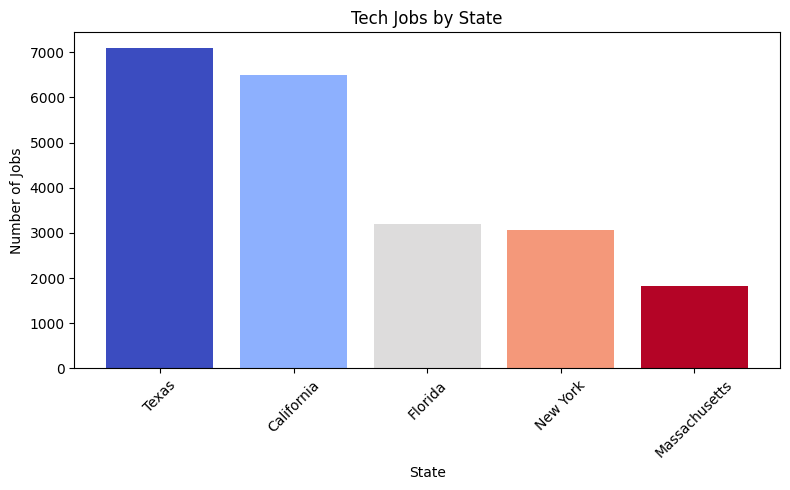

In [68]:
import matplotlib.pyplot as plt
import numpy as np

# Group by STATE_NAME and count jobs for NAICS_2022_6 = 518210
state_counts_jobs = final_df.groupby('STATE_NAME').size().reset_index(name='job_count')

# Sort state_counts_jobs from greatest to least by job_count
state_counts_jobs_sorted = state_counts_jobs.sort_values(by='job_count', ascending=False)

# Plot column chart
plt.figure(figsize=(8, 5))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(state_counts_jobs_sorted)))
plt.bar(state_counts_jobs_sorted['STATE_NAME'], state_counts_jobs_sorted['job_count'], color=colors)
plt.xlabel('State')
plt.ylabel('Number of Jobs')
plt.title('Tech Jobs by State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [71]:
# Print the total count of 'analyst' in LOT_SPECIALIZED_OCCUPATION_NAME
analyst_count = final_df.shape[0]
print(f"Total count of 'analyst' in LOT_SPECIALIZED_OCCUPATION_NAME: {analyst_count}")columns_to_drop = [
    "ID", "URL", "ACTIVE_URLS", "DUPLICATES", "LAST_UPDATED_TIMESTAMP",
    "NAICS2", "NAICS3", "NAICS4", "NAICS5", "NAICS6",
    "SOC_2", "SOC_3", "SOC_5"
]
df.drop(columns=columns_to_drop, inplace=True)

SyntaxError: invalid syntax (2173406893.py, line 3)

In [ ]:
import missingno as msno

# Visualize missing data
msno.heatmap(df)
plt.title("Missing Values Heatmap")
plt.show()

# Drop columns with >50% missing values
df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

# Fill missing values
df["Salary"].fillna(df["Salary"].median(), inplace=True)
df["Industry"].fillna("Unknown", inplace=True)

ModuleNotFoundError: No module named 'missingno'

In [ ]:
df = df.drop_duplicates(subset=["TITLE", "COMPANY", "LOCATION", "POSTED"], keep="first")

In [ ]:
fig = px.bar(df["Industry"].value_counts(), title="Job Postings by Industry")
fig.show()

NameError: name 'px' is not defined